In [1]:
import numpy as np
import glob
import json
from matplotlib import pyplot as plt
from parser import analyze_parser
import os

In [2]:
import matplotlib
font = {'size': 18, 'family': 'serif'}
matplotlib.rc('font', **font)
matplotlib.rcParams['legend.fontsize']='medium'
matplotlib.rcParams["mathtext.fontset"]='cm'

# Define the problem and optimizer to analyze the metrics for

In [3]:
'''
The files with the metrics are stored in 'prob_type/optimizer_type/metrics/*' where prob_type can be 'ALEPH, Gaussian, NF'. The name of the file
will be *.npy and the name will be the value of the weighted_error. 
'''
prob_type = 'ALEPH'  # Choose from ALEPH, Gaussian , NF
optimizer = 'ECD_q1' # Choose from ECD_q1, ECD_q1_F2, adam, lion

### For ALEPH we load in the data for later use

In [4]:
data_vals_reco_full = np.load("inputs/data_vals_reco.npy")
MC_vals_reco_full = np.load("inputs/MC_vals_reco.npy")
MC_vals_truth_full = np.load("inputs/MC_vals_truth.npy")

data_pass_reco = np.load("inputs/data_pass_reco.npy")
MC_pass_reco = np.load("inputs/MC_pass_reco.npy")
MC_pass_truth = np.load("inputs/MC_pass_truth.npy")

data_vals_reco = data_vals_reco_full[data_pass_reco==1]
MC_vals_reco = MC_vals_reco_full[MC_pass_reco==1]
MC_vals_truth = MC_vals_truth_full[MC_pass_truth==1]

Y = np.concatenate([np.ones(len(data_vals_reco)),np.zeros(len(MC_vals_reco))])
X = np.concatenate([data_vals_reco,MC_vals_reco]).reshape(-1,1).astype(np.float32)
N_tot = len(X[Y==1])
print(f'Total data points: {len(X[Y==1])}')

Total data points: 1326351


In [5]:
n_tot, n1_tot = len(data_vals_reco), len(MC_vals_reco)
sim_data_ratio = n1_tot/n_tot

# Obtaining all the metrics in the specificed problem and optimizer

In [6]:
def obtain_sorted_dict(prob_type, optimizer, metric_to_sort, extension_name = ''):
    folder_path = os.path.join(prob_type, optimizer)
    metrics_file_list = glob.glob(folder_path + '/metrics/' + extension_name + '*.npy')
    print(folder_path)
    HP_sweep_dict = []
    for file_name in metrics_file_list:
        # Each file will contain a set of metrics we track for that problem and the optimizer config
        metrics = np.load(file_name, allow_pickle=True).item()
        if prob_type == 'ALEPH' or 'ALEPH_extend':
            n = metrics['n']
            n2_list = metrics['n2_preds']
            n2_list_new = []
            for elem in n2_list:
                # Cut off at T < 0.3
                n2_list_new.append(elem[:-9])

            weighted_mae_notail = np.sum(n[:-9]*np.mean(np.nan_to_num(np.abs(n2_list_new/n[:-9] - 1)), axis = 0)/np.sum(n[:-9]))
            weighted_std_notail = np.std(np.sum(n[:-9]*np.nan_to_num(np.abs(n2_list_new/n[:-9] - 1))/np.sum(n[:-9]), axis = 1))
            metrics.update(weighted_mae_notail=weighted_mae_notail)
            metrics.update(weighted_std_notail=weighted_std_notail)
        HP_sweep_dict.append(metrics)

    ### We can sort the list of dictionaries in ascending order according to 'weighted_mae' or any other scalar metric we choose.
    sorted_dict = sorted(HP_sweep_dict, key=lambda x: (np.round(x[metric_to_sort],4), x['weighted_std_notail']))
    ### Throw away metrics where the average prediction in the first bin contains nan
    sorted_dict = [element for element in sorted_dict if element['n2_avg_pred'][0] == element['n2_avg_pred'][0]]
    
    return sorted_dict

# Analyze top 3 HP configs ordered by `weighted_mae_notail`

In [ ]:
bn = np.linspace(0,0.5,20)
plot_points = 0.5*(bn[0:-1]+bn[1:])
ecd_dict    = obtain_sorted_dict(prob_type, 'ECD_q1', 'weighted_mae_notail')
adam_dict   = obtain_sorted_dict(prob_type, 'adam', 'weighted_mae_notail')
adam_default = obtain_sorted_dict(prob_type, 'adam_default', 'weighted_mae_notail')
ecd_extend_dict = obtain_sorted_dict('ALEPH_extend', 'ECD_q1', 'weighted_mae_notail')
adam_extend_dict = obtain_sorted_dict('ALEPH_extend', 'adam', 'weighted_mae_notail')
ecd_widen_dict = obtain_sorted_dict('ALEPH_widen', 'ECD_q1', 'weighted_mae_notail')
adam_widen_dict = obtain_sorted_dict('ALEPH_widen', 'adam', 'weighted_mae_notail')

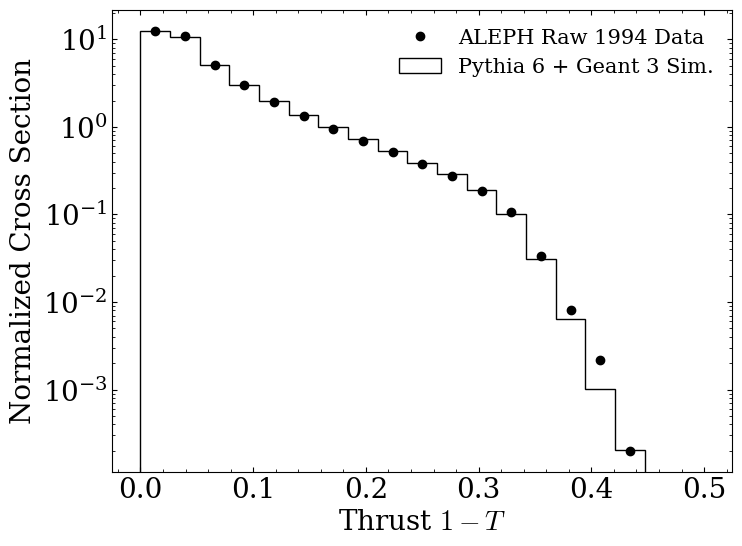

In [9]:
from matplotlib import gridspec
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

n,b = np.histogram(1.-data_vals_reco,density=True,bins=np.linspace(0,0.5,20))
plt.plot(0.5*(b[0:-1]+b[1:]),n,marker='o',color='black',ls="",label="ALEPH Raw 1994 Data")
plt.hist(1.-MC_vals_reco,density=True,bins=np.linspace(0,0.5,20),histtype="step",color="black",label="Pythia 6 + Geant 3 Sim.")
plt.xlabel("Thrust $1-T$",fontsize=20)
plt.ylabel("Normalized Cross Section",fontsize=20)
plt.yscale("log")
plt.legend(frameon=False,fontsize=15)

/tmp/ipykernel_3743/825078486.py:4: RuntimeWarning: invalid value encountered in divide
  error_bars = np.sqrt(n/n1**2*sim_data_ratio**2 + n**2/n1**3*sim_data_ratio**2)


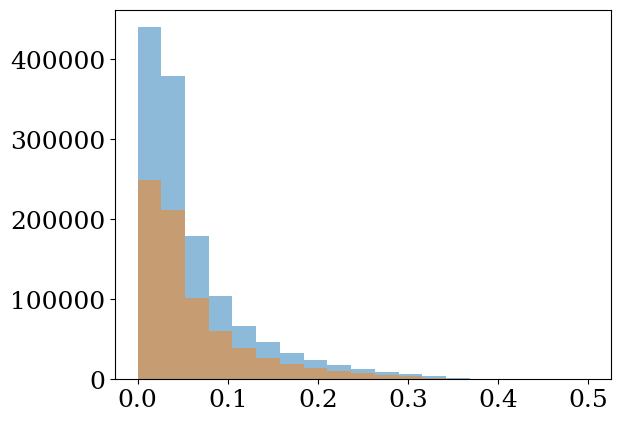

In [12]:
n,bn,_=plt.hist(1.-X[Y==1],density=False,bins=np.linspace(0,0.5,20),alpha=0.5,label="Data")
n1,_,_=plt.hist(1.-X[Y==0],density=False,bins=np.linspace(0,0.5,20),alpha=0.5,label="Sim.")
n2_noweight,_,_=plt.hist(1.-X[Y==0],density=True,bins=np.linspace(0,0.5,20),alpha=0.5,label="Sim.")
error_bars = np.sqrt(n/n1**2*sim_data_ratio**2 + n**2/n1**3*sim_data_ratio**2)
plt.show()

In [ ]:
from matplotlib import gridspec
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(2, 1, height_ratios = [3, 1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.yticks(fontsize=20)
plt.ylabel("Normalized Cross Section",fontsize=16)

n,b = np.histogram(1.-data_vals_reco,density=True,bins=np.linspace(0,0.5,20))
plt.plot(0.5*(b[0:-1]+b[1:]),n,marker='o',color='black',ls="",label="ALEPH Raw 1994 Data")
plt.hist(1.-MC_vals_reco,density=True,bins=np.linspace(0,0.5,20),histtype="step",color="black",label="Pythia 6 + Geant 3 Sim.")
plt.legend(frameon=False,fontsize=15)
plt.yscale("log")


ax1 = plt.subplot(gs[1], sharex=ax0)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
labels = [r'$\mathsf{ECD}_{q=1}$', 'Adam', 'Def. Adam']
for i, element in enumerate([ecd_dict[0], adam_dict[0], adam_default[0]]):
    n = element['n']
    N_bin = N_tot*n/np.sum(n)
    n2_list = element['n2_preds']
    n2_avg = element['n2_avg_pred'] 
    n2_std = np.std(n2_list/n2_noweight, axis = 0)
    weighted_mae = element['weighted_mae_notail']
    weighted_error = element['weighted_error']

    ax1.errorbar(0.5*(b[0:-1]+b[1:]), n2_avg/n2_noweight - element['n']/element['n1'], yerr=n2_std, c = colors[i], label = labels[i])
    eta = element['eta']
    print(f'MAE: {weighted_mae:.2e}, EA: {weighted_error:.2e}, eta: {eta}')
ax1.errorbar(0.5*(b[0:-1]+b[1:]), [0]*len(0.5*(b[0:-1]+b[1:])) , yerr=error_bars, c='red', label = 'Truth', alpha = 0.3)
ax1.set_ylim([-0.015,0.015])
ax1.minorticks_on()

ax1.tick_params(direction="in",which="both")
plt.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.55), ncol = 4, frameon=False, fontsize=12)
plt.tight_layout()
plt.subplots_adjust(hspace=0) 
plt.xlabel("Thrust $1-T$",fontsize=20)
plt.ylabel("Residual")
plt.savefig('ALEPH_plot.pdf', bbox_inches='tight')



## Get MAE and Errors

In [ ]:
for exp in [ecd_dict[0], adam_dict[0], adam_default[0], ecd_extend_dict[0], adam_extend_dict[0], ecd_widen_dict[0], adam_widen_dict[0]]:
    print(exp['weighted_mae_notail'], exp['weighted_std_notail'])